<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EF1p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt


data = scipy.io.loadmat('/content/data.mat')
test = scipy.io.loadmat('/content/test.mat')

X = data['X']
S = data['S']

Xt = test['Xt']
St = test['St']

print('X shape: ', X.shape)
print('S shape: ', S.shape)


X shape:  (60000, 784)
S shape:  (60000, 10)


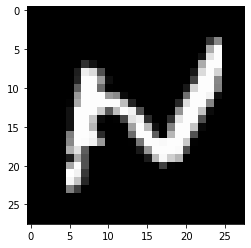

In [2]:
# plot the sample
X_plot = X.reshape(60000, 28, 28)
sample = 0
image = X_plot[sample]
fig = plt.figure

plt.imshow(image, cmap='gray')
plt.show()

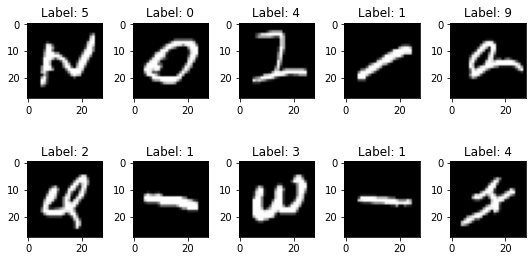

In [3]:
num = 10 # Number of samples to visualize


labels = np.argmax(S, axis=1) + 1
labels = np.where(labels==10, 0, labels)

num_row = 2
num_col = 5
images = X_plot[:num]
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Data processing

### Add ones as the first column of X

In [4]:
N, m = X.shape

ones = np.ones((N, 1))

X = np.append(ones, X, axis = 1)

X.shape

(60000, 785)

### Random permutation:

In [5]:
np.random.seed(261663) # Using my RA as seed

new_order = np.random.permutation(N)
X = X[new_order,:]
S = S[new_order,:]

### Holdout:

  1. 80% training
  2. 20% validation

In [6]:
part = 0.8 # Percentage to divide the data

Xtr = X[0:int((part*N)),:]
Xv = X[int((part*N)):N,:]
Str = S[0:int((part*N)),:]
Sv = S[int((part*N)):,:]

N, m = Xtr.shape 
Nv, mv = Xv.shape

print('After Holdout division:')
print('Number of Training samples:', N)
print('Number of Validation samples:', Nv)

After Holdout division:
Number of Training samples: 48000
Number of Validation samples: 12000


In [7]:
p = np.arange(-8, 20, 2, dtype=float)

print(p)
c = 2**(p)
c

[-8. -6. -4. -2.  0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


array([3.90625e-03, 1.56250e-02, 6.25000e-02, 2.50000e-01, 1.00000e+00,
       4.00000e+00, 1.60000e+01, 6.40000e+01, 2.56000e+02, 1.02400e+03,
       4.09600e+03, 1.63840e+04, 6.55360e+04, 2.62144e+05])

### Crude search for the regularization coefficient:

In [8]:
v_c = []
v_hit_rate_tr = []
v_hit_rate_v = []
hit_rate_max = 0


print('Crude search for the regularization coefficient:')

for p in np.arange(-8, 18, 2, dtype=float):
  C = 2**(p)
  v_c.append(C) # Vector containing every value of crude search

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.dot(np.linalg.inv(np.dot(Xtr.T, Xtr) + C * np.identity(m)), Xtr.T), Str)

  # Training set:
  S_est_tr = np.dot(Xtr, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if S[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr.append(hit_rate_tr)

  # Validation set:
  S_est_v = np.dot(Xv, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max:
    hit_rate_max = hit_rate_v
    c_min = C
    w_min = w


Crude search for the regularization coefficient:


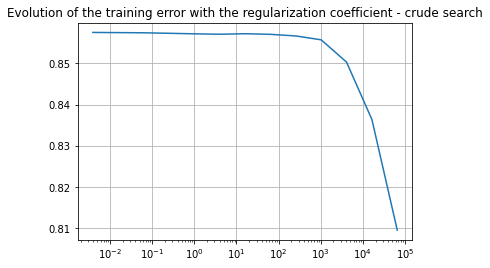

In [9]:
plt.semilogx(v_c, v_hit_rate_tr)
plt.title('Evolution of the training error with the regularization coefficient - crude search')
plt.grid(True)
plt.show()

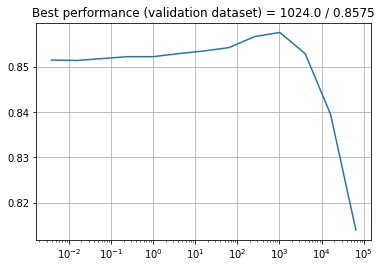

In [10]:
plt.title('Best performance (validation dataset) = {} / {}'.format(c_min, hit_rate_max))
plt.semilogx(v_c, v_hit_rate_v)
plt.grid(True)
plt.show()

### Refined Search:


In [11]:
v_c2 = []
v_hit_rate_tr2 = []
v_hit_rate_v2 = []
hit_rate_max2 = 0

"""
 Given the best crude value for the regularization coeffcient, the refined
 search will consider the interval between the previous and the subsequent
 crude values. 
"""

print('Refined search for the regularization coefficient:')

step = 0.1*(4*c_min-c_min/4)
for p in np.arange(c_min/4, 4*c_min, step, dtype=float):
  C = p
  v_c2.append(C) # Vector containing every value of crude search

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.dot(np.linalg.inv(np.dot(Xtr.T, Xtr) + C * np.identity(m)), Xtr.T), Str)

  # Training set:
  S_est_tr = np.dot(Xtr, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if S[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr2.append(hit_rate_tr)

  # Validation set:
  S_est_v = np.dot(Xv, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v2.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max2:
    hit_rate_max2 = hit_rate_v
    c_min2 = C
    w_min2 = w

Refined search for the regularization coefficient:


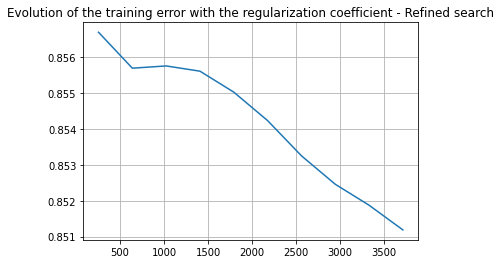

In [12]:
plt.plot(v_c2, v_hit_rate_tr2)
plt.title('Evolution of the training error with the regularization coefficient - Refined search')
plt.grid(True)
plt.show()

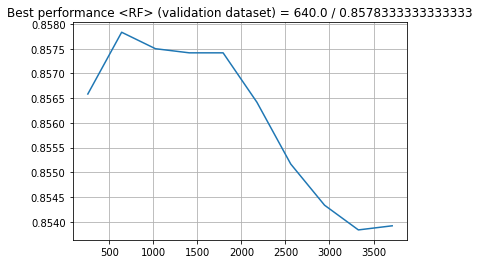

In [13]:
plt.title('Best performance <RF> (validation dataset) = {} / {}'.format(c_min2, hit_rate_max2))
plt.plot(v_c2, v_hit_rate_v2)
plt.grid(True)
plt.show()

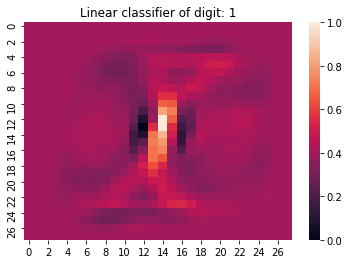

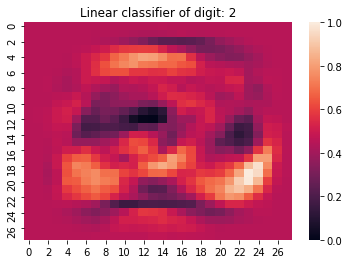

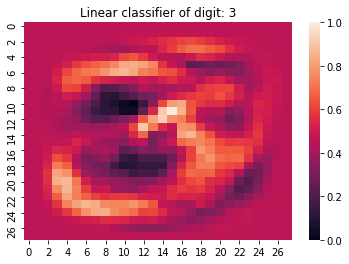

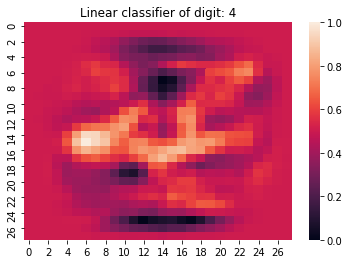

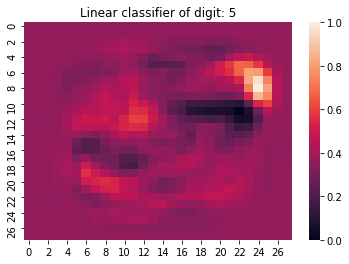

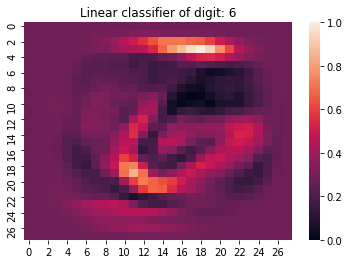

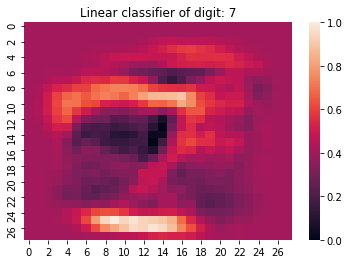

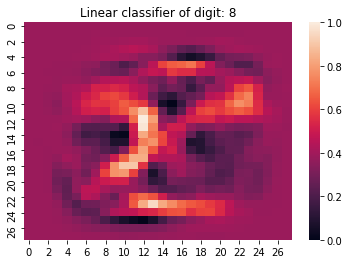

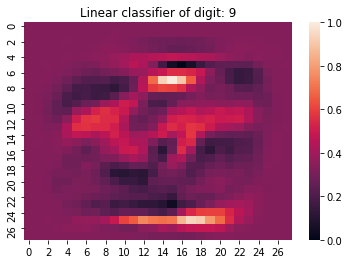

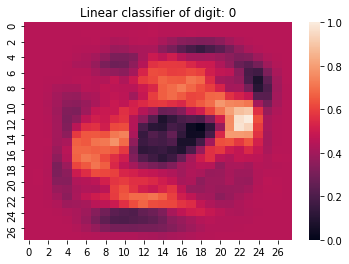

In [24]:
import seaborn as sns


nr, nc = w.shape
IM = np.zeros((28,28))


for i in range(nc):
  if i == nc-1:
    ii = 0
  else:
    ii = i+1
  plt.title('Linear classifier of digit: {}'.format(ii))
  v_aux = (w[1:,i]-np.ndarray.min(w[1:,i]))/(np.ndarray.max(w[1:,i])-np.ndarray.min(w[1:,i]))
  ind = 0
  for j in range(28):
    for k in range(28):
      IM[k,j] = v_aux[ind]
      ind+=1
  # plt.imshow(IM)
  ax = sns.heatmap(IM)
  plt.show()




In [15]:
IM[4,5] = 10

In [16]:
v_aux(5)

TypeError: ignored